In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

/home/pierreo/bo-on-graph


In [4]:
# test the GP cross validation
from problems import get_synthetic_problem
import torch
from search.trust_region import (
    restart,
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from search.utils import eigendecompose_laplacian
from search.models import initialize_model
from scipy.stats import spearmanr


/home/pierreo/miniconda3/envs/graph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# n = 100
# base_problem = get_synthetic_problem(
#     "diffusion", 
#     n=n, 
#     seed=0, 
#     problem_kwargs={
#         "log": False, 
#         "random_graph_type": "ws", 
#         "m": 2,
#         "p": 0.1,
#         "k": 4,
#         "fraction_infected": 2./n,
#         "beta": 0.2,
#         "gamma": 0.,
#         })
# n = 1000
# base_problem = get_synthetic_problem(
#     "centrality", 
#     n=n, 
#     seed=2,
#     problem_kwargs={
#         "log": True, 
#         "random_graph_type": "ba", #ba, ws, sbm
#         "m": 3,
#         # "p": 0.5,
#         # "p": [
#         #     [0.25, 0.02, 0.01], 
#         #     [0.02, 0.35, 0.07], 
#         #     [0.01, 0.07, 0.40]
#         #     ],
#         "sizes":  [75, 75, 300],
#         "k": 4,
#         "beta": 0.2,
#         "gamma": 0.,
#         "feature_name": "eigenvector_centrality"
#         }
#     )

n = 400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "grid",
        "m": 1,
        "n": n,
        "test_function": "sphere"
        }
    )

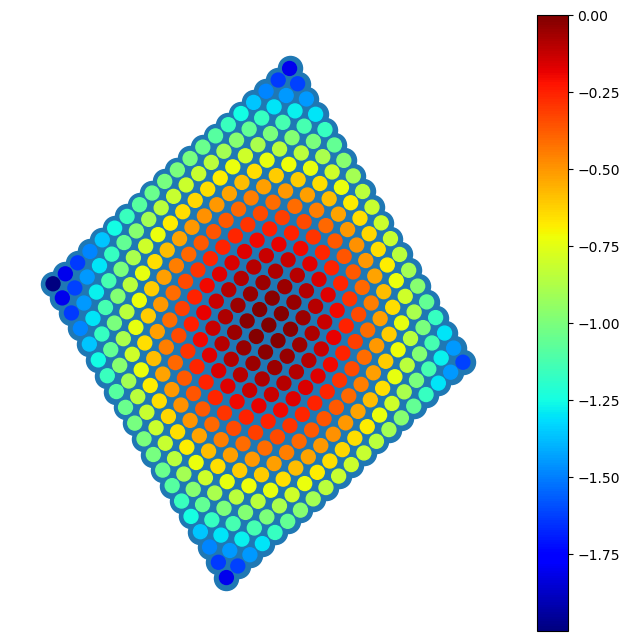

In [6]:
import networkx as nx
pos = nx.kamada_kawai_layout(base_problem.context_graph)
g = base_problem.context_graph
nodes = base_problem.context_graph.nodes()

all_X = torch.arange(len(base_problem.context_graph)).to(torch.float)
all_Y = base_problem(all_X.reshape(-1, 1))
# all_Y = eigenvecs[:, 0]
colors = all_Y
plt.figure(figsize=[8, 8])
nx.draw_networkx(base_problem.context_graph, pos, with_labels=False)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=100, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [7]:
X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)

In [8]:
model, mll, cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="polynomial_new",
                covar_kwargs = {
                    "order": 5,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                optim_kwargs = {
                    "train_iters": 700,
                    "lr": 0.01,
                    "mu_0": 1.,
                    "mu_lower":0.9
                },
                use_saas_map=False
                )


Initialisation kernel... Penalty tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan])
Initialisation kernel... Penalty tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        n

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/home/pierreo/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)


In [62]:
all_X = torch.arange(len(base_problem.context_graph)).to(torch.float)
model.eval()
t = model(all_X)
all_Y = t.rsample()

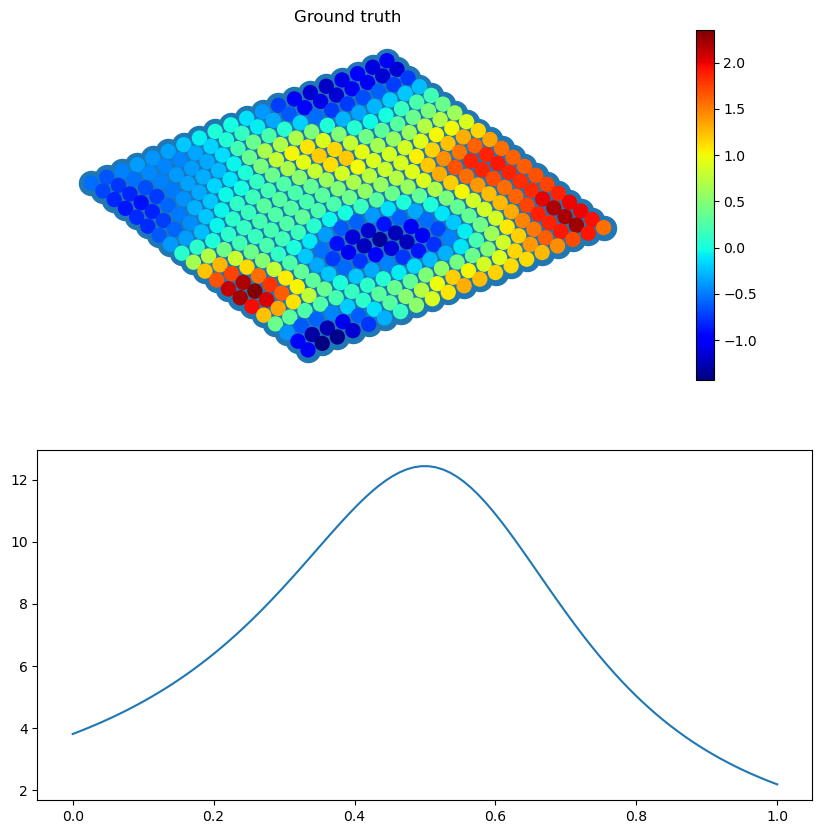

In [63]:
plt.figure(figsize=[10, 10])
plt.subplot(211)
nx.draw_networkx(base_problem.context_graph, pos, with_labels=False)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
c = nx.draw_networkx_nodes(g, pos, node_color=all_Y.detach().numpy(), node_size=100, cmap=plt.cm.jet, linewidths=None, edgecolors=None)

# nc = nx.draw_networkx_nodes(g, train_pos, nodelist=train_X, node_color="gray", node_size=50, cmap=plt.cm.jet, linewidths=0)
# nc = nx.draw_networkx_nodes(g, test_pos, nodelist=test_X, node_color=test_Y, node_size=25, linewidths=0)

plt.colorbar(c)
plt.axis('off')
plt.title("Ground truth")

plt.subplot(212)

beta = model.covar_module.base_kernel.beta.detach().clone()
x = torch.linspace(0,1, 100)
x_result = 1e-6 * torch.ones(x.shape[0])
for i in range(beta.shape[0]):
    x_result += beta[i]*x**i
plt.plot(x, 1/x_result)

In [77]:
# X = candidates.reshape(-1, 1).to(dtype=torch.float)
from botorch.utils.transforms import standardize
n_init = len(all_X)
X = all_X.reshape(-1, 1).detach().copy()


# Y = base_problem(X.reshape(-1, 1))
Y = all_Y.reshape(-1, 1).to(dtype=torch.float).detach().copy()
Y = standardize(Y)

best_loc = Y.argmax().item()
X_best = X[best_loc]

n_train = int(n_init * 0.25)
ntrain_indices = np.random.choice(n_init, n_train, replace=False)
ntest_indices = np.array([i for i in range(n_init) if i not in ntrain_indices])
X_train, Y_train = X[ntrain_indices, ...], Y[ntrain_indices]
X_test, Y_test = X[ntest_indices, ...], Y[ntest_indices, ...]

AttributeError: 'Tensor' object has no attribute 'copy'

In [83]:
import gpytorch
model, mll, cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="polynomial_new",
                covar_kwargs = {
                    "order": 5,
                     },
                fit_model=True,
                ard=True,
                use_fixed_noise=False,
                optim_kwargs = {
                    "train_iters": 700,
                    "lr": 0.001,
                    "mu_0": 10.,
                    "mu_lower":0.9
                },
                use_saas_map=False
                )

Initialisation kernel... Penalty tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan])
Initialisation kernel... Penalty tensor([-2.2628, -2.2382, -2.2126, -2.1859, -2.1583, -2.1299, -2.1007, -2.0709,
        -2.0406, -2.0097, -1.9785, -1.9469, -1.9151, -1.8831, -1.8510, -1.8187,
        -1.7865, -1.7542, -1.7220, -1.6899, -1.6579, -1.6260, -1.5944, -1.5629,
        -1.5316, -1.5006, -1.4699, -1.4395, -1.4093, -1.3794, -1.3499, -1.3207,
        -1.2918, -1.2633, -1.2351, -1.2072, -1.1798, -1.1526, -1.1259, -1

NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.

In [ ]:
import gpytorch
model, mll, cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="polynomial_new",
                covar_kwargs = {
                    "order": 5,
                     },
                fit_model=True,
                ard=True,
                use_fixed_noise=False,
                optim_kwargs = {
                    "train_iters": 700,
                    "lr": 0.01,
                    "mu_0": 1.,
                    "mu_lower":0.9
                },
                use_saas_map=False
                )
